#### Convolution Layer
- 32 x 32 x 3 image $\to$ preserve spatial structure/ local connectivity
- Suppose a layer with 28 x 28 x 5 neurons, the each 5 neurons looking at the same region in the input value. Whereas in the fully connected layer, all neuron looking at the whole input layer
![](images/cnn.png)

To give you some context, modern Convolutional Networks contain on orders of 100 million parameters and are usually made up of approximately 10-20 layers (hence deep learning).

#### Representational power
One way to look at Neural Networks with fully-connected layers is that they define a family of functions that are parameterized by the weights of the network. A natural question that arises is: What is the representational power of this family of functions? In particular, are there functions that cannot be modeled with a Neural Network?

It turns out that Neural Networks with at least one hidden layer are universal approximators. That is, it can be shown (e.g. see Approximation by Superpositions of Sigmoidal Function from 1989 (pdf), or this intuitive explanation from Michael Nielsen) that given any continuous function f(x) and some ϵ>0, there exists a Neural Network g(x) with one hidden layer (with a reasonable choice of non-linearity, e.g. sigmoid) such that $∀x\,∣f(x)−g(x)∣<ϵ$. In other words, the neural network can approximate any continuous function.

If one hidden layer suffices to approximate any function, why use more layers and go deeper? The answer is that the fact that a two-layer Neural Network is a universal approximator is, while mathematically cute, a relatively weak and useless statement in practice. In one dimension, the “sum of indicator bumps” function $g(x)=∑ic_i1(a_i<x<b_i)$ where a,b,c are parameter vectors is also a universal approximator, but noone would suggest that we use this functional form in Machine Learning. Neural Networks work well in practice because __they compactly express nice, smooth functions that fit well with the statistical properties of data we encounter in practice__, and are also easy to learn using our optimization algorithms (e.g. gradient descent). Similarly, the fact that deeper networks (with multiple hidden layers) can work better than a single-hidden-layer networks is an empirical observation, despite the fact that __their representational power is equal__.

As an aside, in practice it is often the case that 3-layer neural networks will outperform 2-layer nets, but going even deeper (4,5,6-layer) rarely helps much more. This is in stark __contrast to Convolutional Networks__, where depth has been found to be an extremely important component for a good recognition system (e.g. on order of 10 learnable layers). One argument for this observation is that __images contain hierarchical structure__ (e.g. faces are made up of eyes, which are made up of edges, etc.), so several layers of processing make intuitive sense for this data domain.

Neural Networks with more neurons can express more complicated functions. However, this is both a blessing (since we can learn to classify more complicated data) and a curse (since it is easier to overfit the training data). Overfitting occurs when a model with high capacity fits the noise in the data instead of the (assumed) underlying relationship. 

Based on our discussion above, it seems that smaller neural networks can be preferred if the data is not complex enough to prevent overfitting. However, this is incorrect - there are many other preferred ways to prevent overfitting in Neural Networks that we will discuss later (such as L2 regularization, dropout, input noise). In practice, it is always better to use these ——__methods to control overfitting__ instead of the number of neurons.

The subtle reason behind this is that smaller networks are harder to train with local methods such as Gradient Descent: It’s clear that their loss functions have relatively __few local minima__, but it turns out that many of these minima are easier to converge to, and that __they are bad__ (i.e. with high loss). Conversely, bigger neural networks contain significantly more local minima, but these minima turn out to be much better in terms of their actual loss. Since Neural Networks are non-convex, it is hard to study these properties mathematically, but some attempts to understand these objective functions have been made. In practice, what you find is that if you train a small network the final loss can display __a good amount of variance__ - in some cases you get lucky and converge to a good place but in some cases you get trapped in one of the bad minima. On the other hand, if you train a large network you’ll start to find many different solutions, but the variance in the final achieved loss will be much smaller. In other words, __all solutions are about equally as good, and rely less on the luck of random initialization__.

#### Output size
(N + 2 x padding - F) / stride + 1
#### Common Settings:
K = (powers of 2, e.g. 32, 64, 128, 512)
- F = 3, S = 1, P = 1
- F = 5, S = 1, P = 2
- F = 5, S = 2, P = ? (whatever fits)
- F = 1, S = 1, P = 0

Zero paddings: artificial edges

Even the input is not squared, usually we still operate square regions and take the same stride since stride gives a sense of sampling.

#### Pooling:
Common settions:
1. F = 2, S = 2
2. F = 3, S = 2

Yeung mentions that recently more and more people use strides instead of max-pooling???

__Backpropagation__. Recall from the backpropagation chapter that the backward pass for a max(x, y) operation has a simple interpretation as only routing the gradient to the input that had the highest value in the forward pass. Hence, during the forward pass of a pooling layer it is common to keep track of the index of the max activation (sometimes also called the switches) so that gradient routing is efficient during backpropagation.

__Getting rid of pooling__. Many people dislike the pooling operation and think that we can get away without it. For example, Striving for Simplicity: The All Convolutional Net proposes to discard the pooling layer in favor of architecture that only consists of repeated CONV layers. To reduce the size of the representation they suggest using larger stride in CONV layer once in a while. Discarding pooling layers has also been found to be important in training good generative models, such as variational autoencoders (VAEs) or generative adversarial networks (GANs). It seems likely that future architectures will feature very few to no pooling layers.

__FC->CONV conversion__. Of these two conversions, the ability to convert an FC layer to a CONV layer is particularly useful in practice. Consider a ConvNet architecture that takes a 224x224x3 image, and then uses a series of CONV layers and POOL layers to reduce the image to an activations volume of size 7x7x512 (in an AlexNet architecture that we’ll see later, this is done by use of 5 pooling layers that downsample the input spatially by a factor of two each time, making the final spatial size 224/2/2/2/2/2 = 7). From there, an AlexNet uses two FC layers of size 4096 and finally the last FC layers with 1000 neurons that compute the class scores. We can convert each of these three FC layers to CONV layers as described above:

- Replace the first FC layer that looks at [7x7x512] volume with a CONV layer that uses filter size F=7, giving output volume [1x1x4096].
- Replace the second FC layer with a CONV layer that uses filter size F=1, giving output volume [1x1x4096]
- Replace the last FC layer similarly, with F=1, giving final output [1x1x1000]

Each of these conversions could in practice involve manipulating (e.g. reshaping) the weight matrix W in each FC layer into CONV layer filters. It turns out that this conversion allows us to “slide” the original ConvNet very efficiently across many spatial positions in a larger image, in a single forward pass.

For example, if 224x224 image gives a volume of size [7x7x512] - i.e. a reduction by 32, then forwarding an image of size 384x384 through the converted architecture would give the equivalent volume in size [12x12x512], since 384/32 = 12. Following through with the next 3 CONV layers that we just converted from FC layers would now give the final volume of size [6x6x1000], since (12 - 7)/1 + 1 = 6. Note that instead of a single vector of class scores of size [1x1x1000], we’re now getting an entire 6x6 array of class scores across the 384x384 image.

Evaluating the original ConvNet (with FC layers) independently across 224x224 crops of the 384x384 image in strides of 32 pixels gives an identical result to forwarding the converted ConvNet one time.

Naturally, forwarding the converted ConvNet a single time is much more efficient than iterating the original ConvNet over all those 36 locations, since the 36 evaluations share computation. This trick is often used in practice to get better performance, where for example, it is common to resize an image to make it bigger, use a converted ConvNet to evaluate the class scores at many spatial positions and then average the class scores.

Lastly, what if we wanted to efficiently apply the original ConvNet over the image but at a stride smaller than 32 pixels? We could achieve this with multiple forward passes. For example, note that if we wanted to use a stride of 16 pixels we could do so by combining the volumes received by forwarding the converted ConvNet twice: First over the original image and second over the image but with the image shifted spatially by 16 pixels along both width and height.

__Prefer a stack of small filter CONV__ to one large receptive field CONV layer. Suppose that you stack three 3x3 CONV layers on top of each other (with non-linearities in between, of course). In this arrangement, each neuron on the first CONV layer has a 3x3 view of the input volume. A neuron on the second CONV layer has a 3x3 view of the first CONV layer, and hence by extension a 5x5 view of the input volume. Similarly, a neuron on the third CONV layer has a 3x3 view of the 2nd CONV layer, and hence a 7x7 view of the input volume. Suppose that instead of these three layers of 3x3 CONV, we only wanted to use a single CONV layer with 7x7 receptive fields. These neurons would have a receptive field size of the input volume that is identical in spatial extent (7x7), but with several disadvantages. First, the neurons would be computing a linear function over the input, while the three stacks of CONV layers contain non-linearities that make their features more expressive. Second, if we suppose that all the volumes have C channels, then it can be seen that the single 7x7 CONV layer would contain C×(7×7×C)=49C2 parameters, while the three 3x3 CONV layers would only contain 3×(C×(3×3×C))=27C2 parameters. Intuitively, stacking CONV layers with tiny filters as opposed to having one CONV layer with big filters allows us to express more powerful features of the input, and with fewer parameters. As a practical disadvantage, we might need more memory to hold all the intermediate CONV layer results if we plan to do backpropagation.

__Layer Sizing Patterns__
Until now we’ve omitted mentions of common hyperparameters used in each of the layers in a ConvNet. We will first state the common rules of thumb for sizing the architectures and then follow the rules with a discussion of the notation:

__The input layer__ (that contains the image) should be divisible by 2 many times. Common numbers include 32 (e.g. CIFAR-10), 64, 96 (e.g. STL-10), or 224 (e.g. common ImageNet ConvNets), 384, and 512.

The conv layers should be using small filters (e.g. 3x3 or at most 5x5), using a stride of S=1, and crucially, padding the input volume with zeros in such way that the conv layer does not alter the spatial dimensions of the input. That is, when F=3, then using P=1 will retain the original size of the input. When F=5, P=2. For a general F, it can be seen that P=(F−1)/2 preserves the input size. If you must use bigger filter sizes (such as 7x7 or so), it is only common to see this on the very first conv layer that is looking at the input image.

The pool layers are in charge of downsampling the spatial dimensions of the input. The most common setting is to use max-pooling with 2x2 receptive fields (i.e. F=2), and with a stride of 2 (i.e. S=2). Note that this discards exactly 75% of the activations in an input volume (due to downsampling by 2 in both width and height). Another slightly less common setting is to use 3x3 receptive fields with a stride of 2, but this makes. It is very uncommon to see receptive field sizes for max pooling that are larger than 3 because the pooling is then too lossy and aggressive. This usually leads to worse performance.

---

#### Implementation as Matrix Multiplication. 

Note that the convolution operation essentially performs __dot products between the filters and local regions__ of the input. A common implementation pattern of the CONV layer is to take advantage of this fact and formulate the forward pass of a convolutional layer as one big matrix multiply as follows:

The local regions in the input image are stretched out into columns in an operation commonly called __im2col__. For example, if the input is [227x227x3] and it is to be convolved with 11x11x3 filters at stride 4, then we would take [11x11x3] blocks of pixels in the input and stretch each block into a column vector of size $11x11x3 = 363$. Iterating this process in the input at stride of 4 gives $(227-11)/4+1 = 55$ locations along both width and height, leading to an output matrix __X_col__ of __im2col__ of size [363 x 3025], where every column is a stretched out receptive field and there are $55*55 = 3025$ of them in total. Note that since the receptive fields overlap, every number in the input volume may be duplicated in multiple distinct columns.

The weights of the CONV layer are similarly stretched out into rows. For example, if there are 96 filters of size [11x11x3] this would give a matrix W_row of size [96 x 363].

The result of a convolution is now equivalent to performing one large matrix multiply np.dot(W_row, X_col), which evaluates the dot product between every filter and every receptive field location. In our example, the output of this operation would be [96 x 3025], giving the output of the dot product of each filter at each location.

The result must finally be __reshaped__ back to its proper output dimension [55x55x96].

This approach has the downside that it can __use a lot of memory__, since some values in the input volume are replicated multiple times in __X_col__. However, the benefit is that there are many very efficient implementations of Matrix Multiplication that we can take advantage of (for example, in the commonly used BLAS API). Moreover, the same im2col idea can be reused to perform the pooling operation, which we discuss next.

#### Initialization
It’s not necessarily the case that smaller numbers will work strictly better. For example, a Neural Network layer that has very small weights will during backpropagation compute __very small gradients__ on its data (since this gradient is proportional to the value of the weights). This could greatly diminish the “gradient signal” flowing backward through a network, and could become a concern for deep networks.

__Calibrating the variances with 1/sqrt(n)__. One problem with the above suggestion is that __the distribution of the outputs from a randomly initialized neuron has a variance that grows with the number of inputs__. It turns out that we can normalize the variance of each neuron’s output to 1 by scaling its weight vector by the square root of its fan-in (i.e. its number of inputs). That is, the recommended heuristic is to initialize each neuron’s weight vector as: `w = np.random.randn(n) / sqrt(n)` where n is the number of its inputs. This ensures that all neurons in the network initially __have approximately the same output distribution and empirically improves the rate of convergence__.

The sketch of the derivation is as follows: Consider the inner product $s=∑n_iw_ix_i$ between the weights w and input x, which gives the raw activation of a neuron before the non-linearity. We can examine the variance of s:
$$\begin{align*}
\text{Var}(s) & = \text{Var}(\sum_i^nw_ix_i) \\
& = ∑_i^n \text{Var}(w_ix_i) \\
& =\sum_i^n[E(w_i)]^2\text{Var}(x_i)+ E[(x_i)]^2 \text{Var}(w_i)+ \text{Var}(x_i) \text{Var}(w_i) \\
& = ∑_i^n \text{Var}(x_i) \text{Var}(w_i) \\
& = (n \text{Var}(w)) \text{Var}(x)
\end{align*}$$
where in the first 2 steps we have used properties of variance. 

A similar analysis is carried out in __Understanding the difficulty of training deep feedforward neural networks__ by Glorot et al. In this paper, the authors end up recommending an initialization of the form $\text{Var}(w)=2/(n_{in}+n_{out})$ where $n_{in}$,$n_{out}$ are the number of units in the previous layer and the next layer. This is based on a compromise and an equivalent analysis of the backpropagated gradients. A more recent paper on this topic, __Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification__ by He et al., derives an initialization specifically for ReLU neurons, reaching the conclusion that the variance of neurons in the network should be 2.0/n. This gives the initialization $$w = np.random.randn(n) * sqrt(2.0/n)$$ and is the current recommendation for use in practice in the specific case of neural networks with ReLU neurons.

__Sparse initialization__. Another way to address the uncalibrated variances problem is to __set all weight matrices to zero__, but to break symmetry every neuron is __randomly connected__ (with weights sampled from a small gaussian as above) to a fixed number of neurons below it. A typical number of neurons to connect to may be as small as __10__.

__Initializing the biases__. It is possible and common to initialize the biases to be zero, since the asymmetry breaking is provided by the small random numbers in the weights. For ReLU non-linearities, some people like to use __small constant value such as 0.01 for all biases__ because this ensures that all ReLU units __fire in the beginning__ and therefore obtain and propagate some gradient. However, it is not clear if this provides a consistent improvement (in fact some results seem to indicate that this performs worse) and it is more common to simply use 0 bias initialization.

__Batch Normalization__. A recently developed technique by Ioffe and Szegedy called Batch Normalization alleviates a lot of headaches with properly initializing neural networks by explicitly __forcing the activations throughout a network to take on a unit gaussian distribution at the beginning of the training__. The core observation is that this is possible because normalization is a __simple differentiable operation__. In the implementation, applying this technique usually amounts to insert the BatchNorm layer __immediately after fully connected layers (or convolutional layers__, as we’ll soon see), and __before non-linearities__. Note that it has become a very common practice to use Batch Normalization in neural networks. In practice networks that use Batch Normalization are significantly __more robust to bad initialization__. Additionally, batch normalization can be interpreted as __doing preprocessing at every layer of the network__, but __integrated into the network itself in a differentiable manner__. Neat!

<img src = "images/bn.png" width = '600px'/>
In test case, use the mean and variance of the whole training dataset. And in practice, it doesn't learn the identity mapping.

<img src = "images/l1.png" width = '600px'/>
<img src = "images/l2.png" width = '600px'/>
<img src = "images/l3.png" width = '600px'/>

<img src = "images/training.png" width = '600px'/>

<img src = "images/track.png" width = '600px'/>

__Max norm constraints__. Another form of regularization is to enforce an absolute upper bound on the magnitude of the weight vector for every neuron and use projected gradient descent to enforce the constraint. In practice, this corresponds to performing the parameter update as normal, and then enforcing the constraint by clamping the weight vector w⃗  of every neuron to satisfy ∥w⃗ ∥2<c. Typical values of c are on orders of 3 or 4. Some people report improvements when using this form of regularization. One of its appealing properties is that network cannot “explode” even when the learning rates are set too high because the updates are always bounded.

__Dropout__ is an extremely effective, simple and recently introduced regularization technique by Srivastava et al. in Dropout: A Simple Way to Prevent Neural Networks from Overfitting (pdf) that complements the other methods (L1, L2, maxnorm). While training, dropout is implemented by only keeping a neuron active with some probability p (a hyperparameter), or setting it to zero otherwise.

Crucially, note that in the predict function we are not dropping anymore, but we are performing a scaling of both hidden layer outputs by p. This is important because at test time all neurons see all their inputs, so we want the outputs of neurons at test time to be identical to their expected outputs at training time. For example, in case of p=0.5, the neurons must halve their outputs at test time to have the same output as they had during training time (in expectation). 

```python
""" Vanilla Dropout: Not recommended implementation (see notes below) """

p = 0.5 # probability of keeping a unit active. higher = less dropout

def train_step(X):
  """ X contains the data """
  
  # forward pass for example 3-layer neural network
  H1 = np.maximum(0, np.dot(W1, X) + b1)
  U1 = np.random.rand(*H1.shape) < p # first dropout mask
  H1 *= U1 # drop!
  H2 = np.maximum(0, np.dot(W2, H1) + b2)
  U2 = np.random.rand(*H2.shape) < p # second dropout mask
  H2 *= U2 # drop!
  out = np.dot(W3, H2) + b3
  
  # backward pass: compute gradients... (not shown)
  # perform parameter update... (not shown)
  
def predict(X):
  # ensembled forward pass
  H1 = np.maximum(0, np.dot(W1, X) + b1) * p # NOTE: scale the activations
  H2 = np.maximum(0, np.dot(W2, H1) + b2) * p # NOTE: scale the activations
  out = np.dot(W3, H2) + b3
```

The undesirable property of the scheme presented above is that we must scale the activations by p at test time. Since test-time performance is so critical, it is always preferable to use __inverted dropout__, which performs the scaling at train time, leaving the forward pass at test time untouched. Additionally, this has the appealing property that the prediction code can remain untouched when you decide to tweak where you apply dropout, or if at all.

In CNN, one may disable an feature map instead of random elements. It could avoid co-adaption features. It's training a large ensemble of models. In testing session, want to approximate the integral, so average randomness.
$$y = f(x) = E_z[f(x, z)] = \int p(z) f(x, z) dz$$

- DropConnect
- Fractional Max pooling
- Stochastic Depth
- Data augmentation

## Activation functions
1. Sigmoid
    - Have nice interpretation as a saturating "firing rate"
    - X Cons:
        1. May kill of the gradient
        2. Is not zero-centered which updates the weights very inefficiently. For example the figure below, we cannot update along the blue line directly since only two quadrants are allowed to make a gradient update. <img src = "images/sig.png" width = '600px'/>
2. Tanh
    - Zero centered
    - X Kill gradients when saturated
2. Relu
    - Biologically plausible than sigmoid
    - Converge faster e.g. 6x
    - Does not saturate in the positive direction
    - X Not zero-centered
    - Dead Relu -- Half of the plane never activate， Reasons:
        1. Bad initializations
        2. Learning rate too high
    - So in practice, people may prefer to initialize ReLU neurons with slightly postive biases (not usually used)
4. Leaky Relu
5. PReLU:
    $f = \max(\alpha x, x)$ and backprop into $\alpha$
6. ELU:
    - $f(x) = \begin{cases} x & \text{if} x > 0 \\ \alpha(\exp(x) - 1) & \text{if} x \le 0\end{cases}$
    - Negative saturation regime which add some robustness to noise
7. Maxout:
    - max(W_1X + b_1, W_2X + b_2)
    - Generalize ReLU and LeakyReLU
    - X doubles the number of parameters

#### Data Preprocessing
<img src = "images/nm.png" width = '600px'/>
We mention PCA/Whitening in these notes for completeness, but these transformations are not used with Convolutional Networks. However, it is very important to zero-center the data, and it is common to see normalization of every pixel as well.

<img src = "images/pca.png" width = '600px'/>
Warning: Exaggerating noise. Note that we’re adding 1e-5 (or a small constant) to prevent division by zero. One weakness of this transformation is that it can greatly exaggerate the noise in the data, since it stretches all dimensions (including the irrelevant dimensions of tiny variance that are mostly noise) to be of equal size in the input. This can in practice be mitigated by stronger smoothing (i.e. increasing 1e-5 to be a larger number).

<img src = "images/norm.png" width = '600px'/>

---

## Optimization
#### Problems with SGD
1. Very slow progress along shallow dimension, jitter along steep direction (zigzag)
1. saddle points
2. noisy gradients (we just get some noisy estimations about the gradient at current step)

#### SGD + Momentum
- Initialization of the velocity is always __zero__
- May help to get over local optima and saddle points
- Zigzag will cancel each other out pretty fast
- More recent gradients weighted heavier
<img src = "images/mom.png" width = '600px'/>

#### Nesterov Momentum
<img src = "images/nem.png" width = '600px'/>

#### Adapt
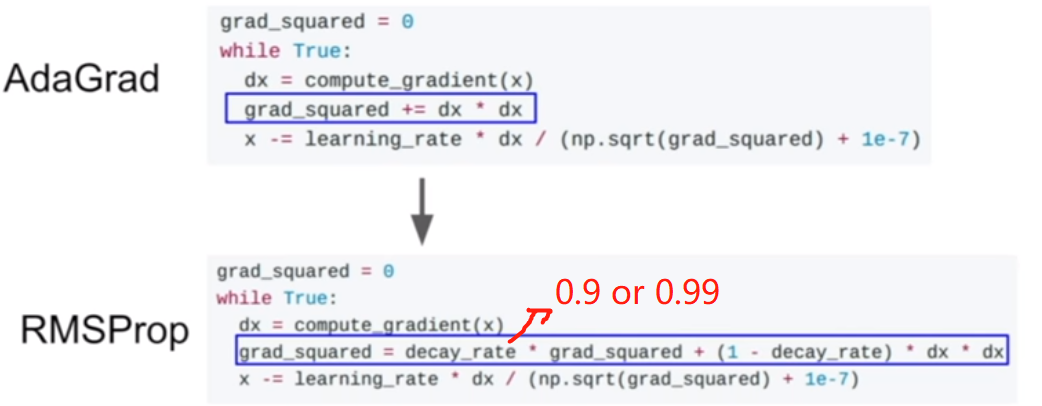

#### Adam

<img src = "images/adam.png" width = '600px'/>

Second Order op doesn't perform well on non-convex problems

#### Reduce the gap between training error and testing error
1. Model Ensembles:
    - Train multiple models and average their result. The hyperparams may be different
    - Or just keep multiple snapshots of your model
<img src = "images/me.png" width = '600px'/>

<img src = 'images/lrd.png' width = '300px'>

![](images/es.png)

High initial learning rates can make loss explode; linearly increasing learning rate from 0 over the first ~5000 iterations can
prevent this 
Empirical rule of thumb: If you increase the batch size by N, also scale the initial learning rate by N

#### Choosing Hyperparameters
1. Check initial loss
2. Overfit a small sample
3. Find LR that makes loss go down
4. Coarse grid, train for ~1-5 epochs
5. Refine grid, train longer
6. Look at loss curves

![](images/bi.png)
![](images/lp.png)
![](images/e.png)
![](images/l.png)
![](images/o.png)
![](images/u.png)